In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets
from torch.utils.data import Dataset,DataLoader,random_split,Subset
import matplotlib.pyplot as plt 
import pandas as pd
import os
from PIL import Image
from DataPreparation.CustomDataSet import CustomDataSet
from AutoEncoders.SimpleAutoencoder import AutoEncoder
import numpy as np
import pickle
from  sklearn.svm import SVC

In [2]:
from Pruning.laprune import LAP 

In [3]:
def transform(input):
    input = torch.FloatTensor(np.array(input))
    input = input.flatten()
    input = input.type(torch.FloatTensor)
    input -= torch.min(input)
    input /= torch.max(input)
    return input

In [55]:
dataset = CustomDataSet("DataPreparation/CorruptedFashionMNIST/Names.csv",
                      "DataPreparation/CorruptedFashionMNIST", transform=transform)

In [56]:
# finding the best parameters for autoencoder 
train_size = int(0.3 * len(dataset))  # int(0.3 * len(dataset)) 80% for training
validation_size = int(0.1*len(dataset))
test_size = 0.1 #len(dataset)-(train_size+validation_size)
train_dataset,validation_dataset,test_dataset, _ = random_split(dataset,[0.1,0.1,0.1, 0.7])
print(train_size)
print(validation_size)

# Create DataLoader instances
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(validation_dataset,batch_size=64,shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64,shuffle=True)

18000
6000


In [4]:
def train_autoencoder(model, train_loader, val_loader, epochs, lr=0.01):
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()
        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            model.train()  # Set model to training mode
            total_train_loss = 0
            for X_batch, _ in train_loader:
                X_batch = X_batch.view(X_batch.size(0), -1)  # Reshape if necessary
                optimizer.zero_grad()
                outputs = model(X_batch)
                train_loss = criterion(outputs, X_batch)
                train_loss.backward()
                optimizer.step()
                total_train_loss += train_loss.item()
            avg_train_loss = total_train_loss / len(train_loader)
            train_losses.append(avg_train_loss)

                # Validation
            model.eval()  # Set model to evaluation mode
            total_val_loss = 0
            with torch.no_grad():
                for X_batch, _ in val_loader:
                    X_batch = X_batch.view(X_batch.size(0), -1)  # Reshape if necessary
                    outputs = model(X_batch)
                    val_loss = criterion(outputs, X_batch)
                    total_val_loss += val_loss.item()
            avg_val_loss = total_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        return train_losses, val_losses

In [58]:
model = AutoEncoder(input_size=784,bottleneck_size=50,hidden_sizes=[128, 64] ,layers=2)
train_losses,val_losses = train_autoencoder(model, train_loader=train_dataloader,val_loader=validation_dataloader,epochs=100,lr=0.0003)

Epoch 1, Train Loss: 0.1025, Val Loss: 0.0414
Epoch 2, Train Loss: 0.0411, Val Loss: 0.0406
Epoch 3, Train Loss: 0.0378, Val Loss: 0.0318
Epoch 4, Train Loss: 0.0263, Val Loss: 0.0223
Epoch 5, Train Loss: 0.0217, Val Loss: 0.0205
Epoch 6, Train Loss: 0.0201, Val Loss: 0.0192
Epoch 7, Train Loss: 0.0189, Val Loss: 0.0180
Epoch 8, Train Loss: 0.0177, Val Loss: 0.0167
Epoch 9, Train Loss: 0.0165, Val Loss: 0.0158
Epoch 10, Train Loss: 0.0158, Val Loss: 0.0153
Epoch 11, Train Loss: 0.0153, Val Loss: 0.0149
Epoch 12, Train Loss: 0.0151, Val Loss: 0.0147
Epoch 13, Train Loss: 0.0148, Val Loss: 0.0144
Epoch 14, Train Loss: 0.0145, Val Loss: 0.0140
Epoch 15, Train Loss: 0.0141, Val Loss: 0.0137
Epoch 16, Train Loss: 0.0139, Val Loss: 0.0135
Epoch 17, Train Loss: 0.0137, Val Loss: 0.0134
Epoch 18, Train Loss: 0.0135, Val Loss: 0.0132
Epoch 19, Train Loss: 0.0133, Val Loss: 0.0130
Epoch 20, Train Loss: 0.0131, Val Loss: 0.0128
Epoch 21, Train Loss: 0.0129, Val Loss: 0.0125
Epoch 22, Train Loss: 

In [59]:
def eval_model(model, dataset, classifier):
    #model.eval()
    #criterion = nn.MSELoss()
    #total_loss = 0
    #with torch.no_grad():
     #   for X_batch, _ in data_loader:
     #       X_batch = X_batch.view(X_batch.size(0), -1)
     #       outputs = model(X_batch)
     #       loss = criterion(outputs, X_batch)
     #       total_loss += loss.item()
    #avg_loss = total_loss / len(data_loader)
    with torch.no_grad():
        data_loader = DataLoader(dataset, batch_size=len(dataset), shuffle=True)
        for images, labels in data_loader:
            reconstructed = model(images)
            accuracy = classifier.score(reconstructed.detach().numpy(), labels)
            
            return accuracy


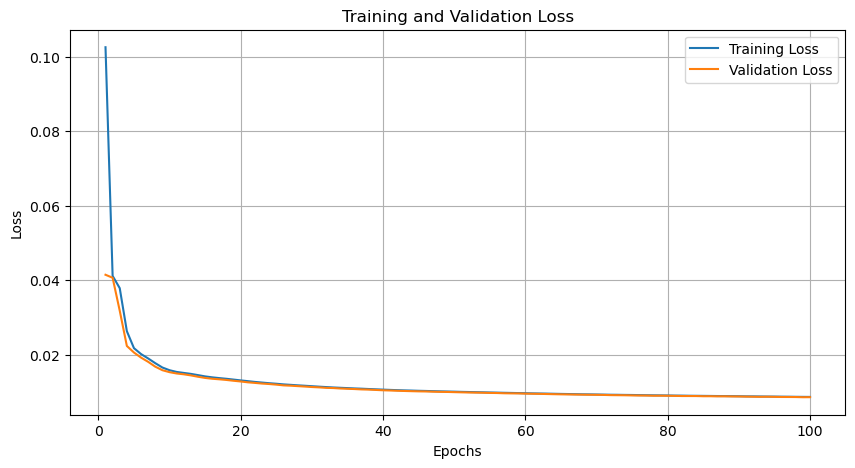

In [60]:
import matplotlib.pyplot as plt

# Assuming train_losses and val_losses are the lists returned from the train_autoencoder method
epochs = range(1, 100 + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [61]:
with open("Classifiers/CorrputedFashionMNISTClassifier.pkl", "rb") as f:
    fashion_mnist_classifier = pickle.load(f)

In [62]:
import copy
import matplotlib.pyplot as plt
from Pruning.LookaheadPruning import apply_lap, calculate_sparsity

# Assuming 'model' is your pre-trained AutoEncoder and 'test_dataloader' is defined
prune_ratios = [0.02, 0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9]  # Define desired prune ratios to apply
sparsity_levels_LAP = []  # This will store the actual sparsity levels calculated from the model
test_losses_LAP = []

for ratio in prune_ratios:
    # Create a deep copy of the trained model to apply pruning
    pruned_model = copy.deepcopy(model)
    
    # Apply LAP pruning using the specified prune ratio
    apply_lap(pruned_model, [ratio] * len(pruned_model.hidden_sizes), bn_factors=None)
    
    # Calculate the actual sparsity level of the pruned model
    sparsity = calculate_sparsity(pruned_model)
    sparsity_levels_LAP.append(sparsity)
    
    # Evaluate the pruned model on the test dataset
    test_loss = eval_model(pruned_model, test_dataset, fashion_mnist_classifier)
    test_losses_LAP.append(test_loss)
    print(f"Prune Ratio: {ratio}, Actual Sparsity Level: {sparsity:.4f}, Test Loss: {test_loss:.4f}")


Prune Ratio: 0.02, Actual Sparsity Level: 0.0180, Test Loss: 0.7850
Prune Ratio: 0.2, Actual Sparsity Level: 0.1796, Test Loss: 0.7873
Prune Ratio: 0.3, Actual Sparsity Level: 0.2694, Test Loss: 0.7767
Prune Ratio: 0.4, Actual Sparsity Level: 0.3592, Test Loss: 0.7607
Prune Ratio: 0.5, Actual Sparsity Level: 0.4490, Test Loss: 0.7003
Prune Ratio: 0.6, Actual Sparsity Level: 0.5388, Test Loss: 0.5833
Prune Ratio: 0.7, Actual Sparsity Level: 0.6286, Test Loss: 0.5087
Prune Ratio: 0.8, Actual Sparsity Level: 0.7184, Test Loss: 0.3850
Prune Ratio: 0.9, Actual Sparsity Level: 0.8082, Test Loss: 0.1135


In [63]:
import Pruning.ShapSAE as SSAE
test_data = [data for data in test_dataloader]
pruned_model = copy.deepcopy(model)
importances = SSAE.calc_importance(pruned_model,test_data[0][0])

0it [00:00, ?it/s]
100%|██████████| 8/8 [00:54<00:00,  6.81s/it]
1it [00:54, 54.45s/it]
100%|██████████| 21/21 [02:21<00:00,  6.74s/it]
3it [03:15, 66.52s/it]
  1%|          | 2/251 [00:13<27:31,  6.63s/it]divide by zero encountered in log
invalid value encountered in divide

  2%|▏         | 6/251 [00:39<27:11,  6.66s/it]divide by zero encountered in log
invalid value encountered in divide

  3%|▎         | 7/251 [00:46<27:01,  6.64s/it]divide by zero encountered in log
invalid value encountered in divide

  4%|▎         | 9/251 [00:59<26:38,  6.61s/it]divide by zero encountered in log
invalid value encountered in divide

  9%|▉         | 22/251 [02:26<25:26,  6.66s/it]divide by zero encountered in log
invalid value encountered in divide

 13%|█▎        | 32/251 [03:45<30:50,  8.45s/it]divide by zero encountered in log
invalid value encountered in divide

 18%|█▊        | 45/251 [05:37<29:41,  8.65s/it]divide by zero encountered in log
invalid value encountered in divide

 21%|██     

In [64]:


# Assuming 'model' is your pre-trained AutoEncoder and 'test_dataloader' is defined
prune_ratios = [0.02, 0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9]  # Define desired prune ratios to apply
sparsity_levels = []  # This will store the actual sparsity levels calculated from the model
test_losses = []



for ratio in prune_ratios:
    # Create a deep copy of the trained model to apply pruning
    pruned_model = copy.deepcopy(model)
    
    # Apply LAP pruning using the specified prune ratio
    pruned_model, _ = SSAE.prune(pruned_model, importances, ratio)
    
    
    # Evaluate the pruned model on the test dataset
    test_loss = eval_model(pruned_model, test_dataset, fashion_mnist_classifier)
    test_losses.append(test_loss)
    print(f"Prune Ratio: {ratio}, Actual Sparsity Level: {sparsity:.4f}, Test Loss: {test_loss:.4f}")

5it [00:00, 714.19it/s]


Prune Ratio: 0.02, Actual Sparsity Level: 0.8082, Test Loss: 0.6750


5it [00:00, 833.73it/s]


Prune Ratio: 0.2, Actual Sparsity Level: 0.8082, Test Loss: 0.1973


5it [00:00, 833.46it/s]


Prune Ratio: 0.3, Actual Sparsity Level: 0.8082, Test Loss: 0.0985


5it [00:00, 833.69it/s]


Prune Ratio: 0.4, Actual Sparsity Level: 0.8082, Test Loss: 0.0985


5it [00:00, 833.29it/s]


Prune Ratio: 0.5, Actual Sparsity Level: 0.8082, Test Loss: 0.0983


5it [00:00, 999.41it/s]


Prune Ratio: 0.6, Actual Sparsity Level: 0.8082, Test Loss: 0.0988


5it [00:00, 1250.02it/s]


Prune Ratio: 0.7, Actual Sparsity Level: 0.8082, Test Loss: 0.1052


5it [00:00, 1249.79it/s]


Prune Ratio: 0.8, Actual Sparsity Level: 0.8082, Test Loss: 0.1052


5it [00:00, 1248.97it/s]


Prune Ratio: 0.9, Actual Sparsity Level: 0.8082, Test Loss: 0.1052


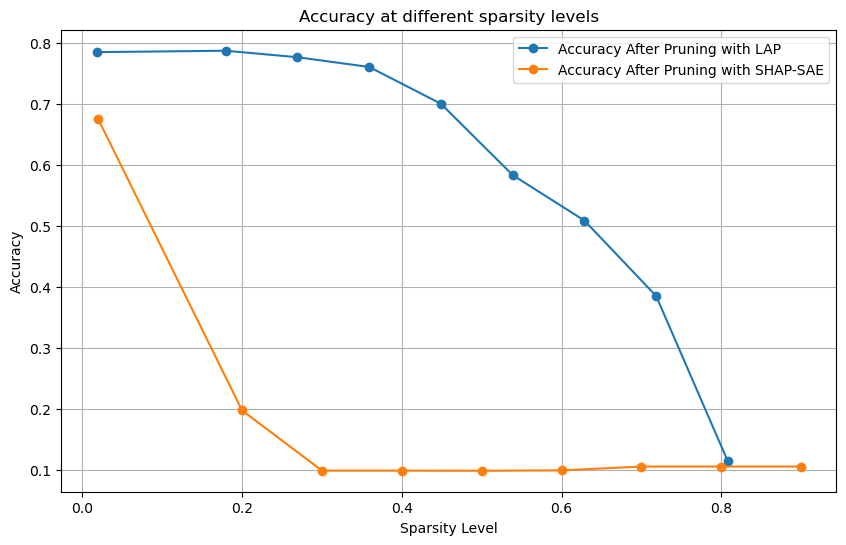

In [66]:
plt.figure(figsize=(10, 6))
plt.plot(sparsity_levels_LAP, test_losses_LAP, '-o', label='Accuracy After Pruning with LAP')
plt.plot(prune_ratios, test_losses, '-o', label='Accuracy After Pruning with SHAP-SAE')

plt.xlabel('Sparsity Level')
plt.ylabel('Accuracy')
plt.title('Accuracy at different sparsity levels')
plt.legend()
plt.grid(True)
plt.show()

5it [00:00, 833.63it/s]
5it [00:00, 999.88it/s]
5it [00:00, 999.83it/s]
5it [00:00, 999.60it/s]
5it [00:00, 1000.41it/s]
5it [00:00, 1000.45it/s]
5it [00:00, 1000.26it/s]
5it [00:00, 999.74it/s]


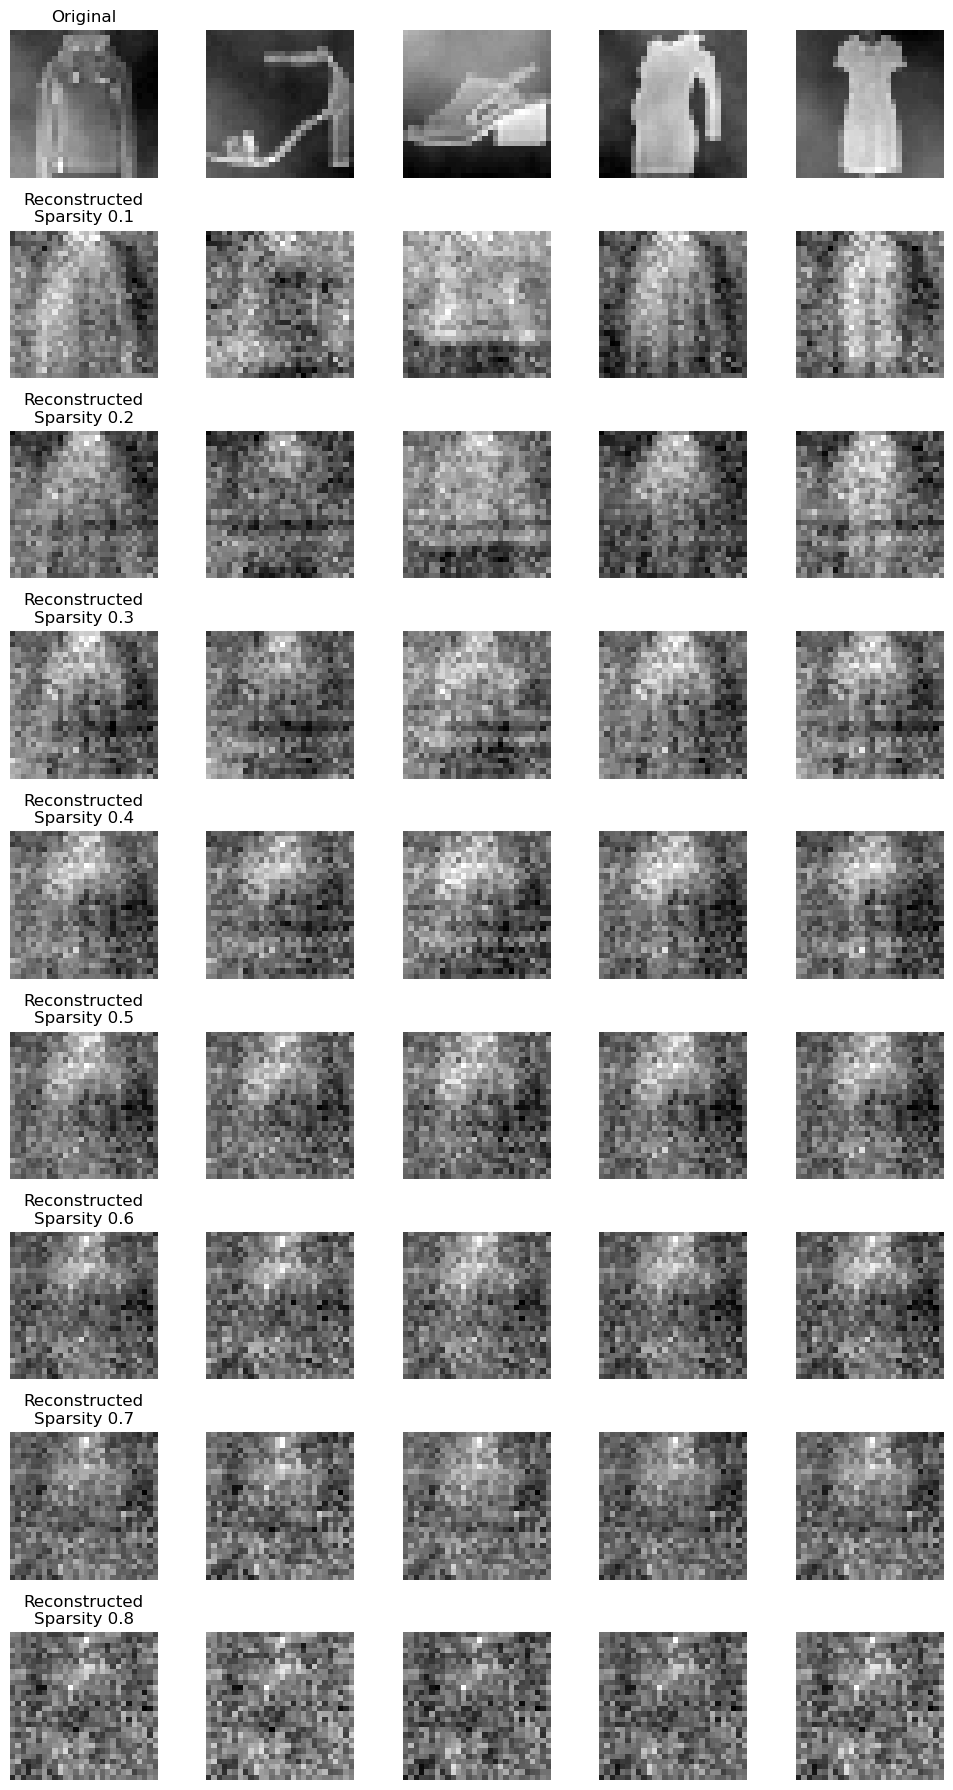

In [15]:
def display_reconstructed_images_SHAP(model, test_dataloader, importances, importance_levels):
    # Select a batch of images from the test DataLoader.
    test_images, _ = next(iter(test_dataloader))
    original_images = test_images.view(test_images.size(0), -1)

    # Set the number of images to display
    num_images_to_show = 5
    fig, axes = plt.subplots(len(prune_ratios) + 1, num_images_to_show, figsize=(num_images_to_show * 2, 2 * (len(prune_ratios) + 1)))

    # Display original images
    for i in range(num_images_to_show):
        ax = axes[0][i]
        ax.imshow(original_images[i].view(28, 28).cpu().numpy(), cmap='gray')  # Adjust dimensions for your dataset
        ax.axis('off')
        if i == 0:
            ax.set_title('Original')

    # Display reconstructed images at each sparsity level
    for j, sparsity in enumerate(importance_levels, start=1):
        # Prune the model copy at the current sparsity level
        pruned_model = copy.deepcopy(model)
        pruned_model, _ = SSAE.prune(pruned_model, importances, sparsity)

        # Generate reconstructed images from the pruned model
        pruned_model.eval()
        with torch.no_grad():
            reconstructed_images = pruned_model(original_images).cpu()

        # Plot the reconstructed images
        for i in range(num_images_to_show):
            ax = axes[j][i]
            ax.imshow(reconstructed_images[i].view(28, 28).cpu().numpy(), cmap='gray')  # Adjust dimensions for your dataset
            ax.axis('off')
            if i == 0:
                ax.set_title(f'Reconstructed\nSparsity {sparsity}')

    plt.tight_layout()
    plt.show()

display_reconstructed_images_SHAP(model, test_dataloader, importances, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

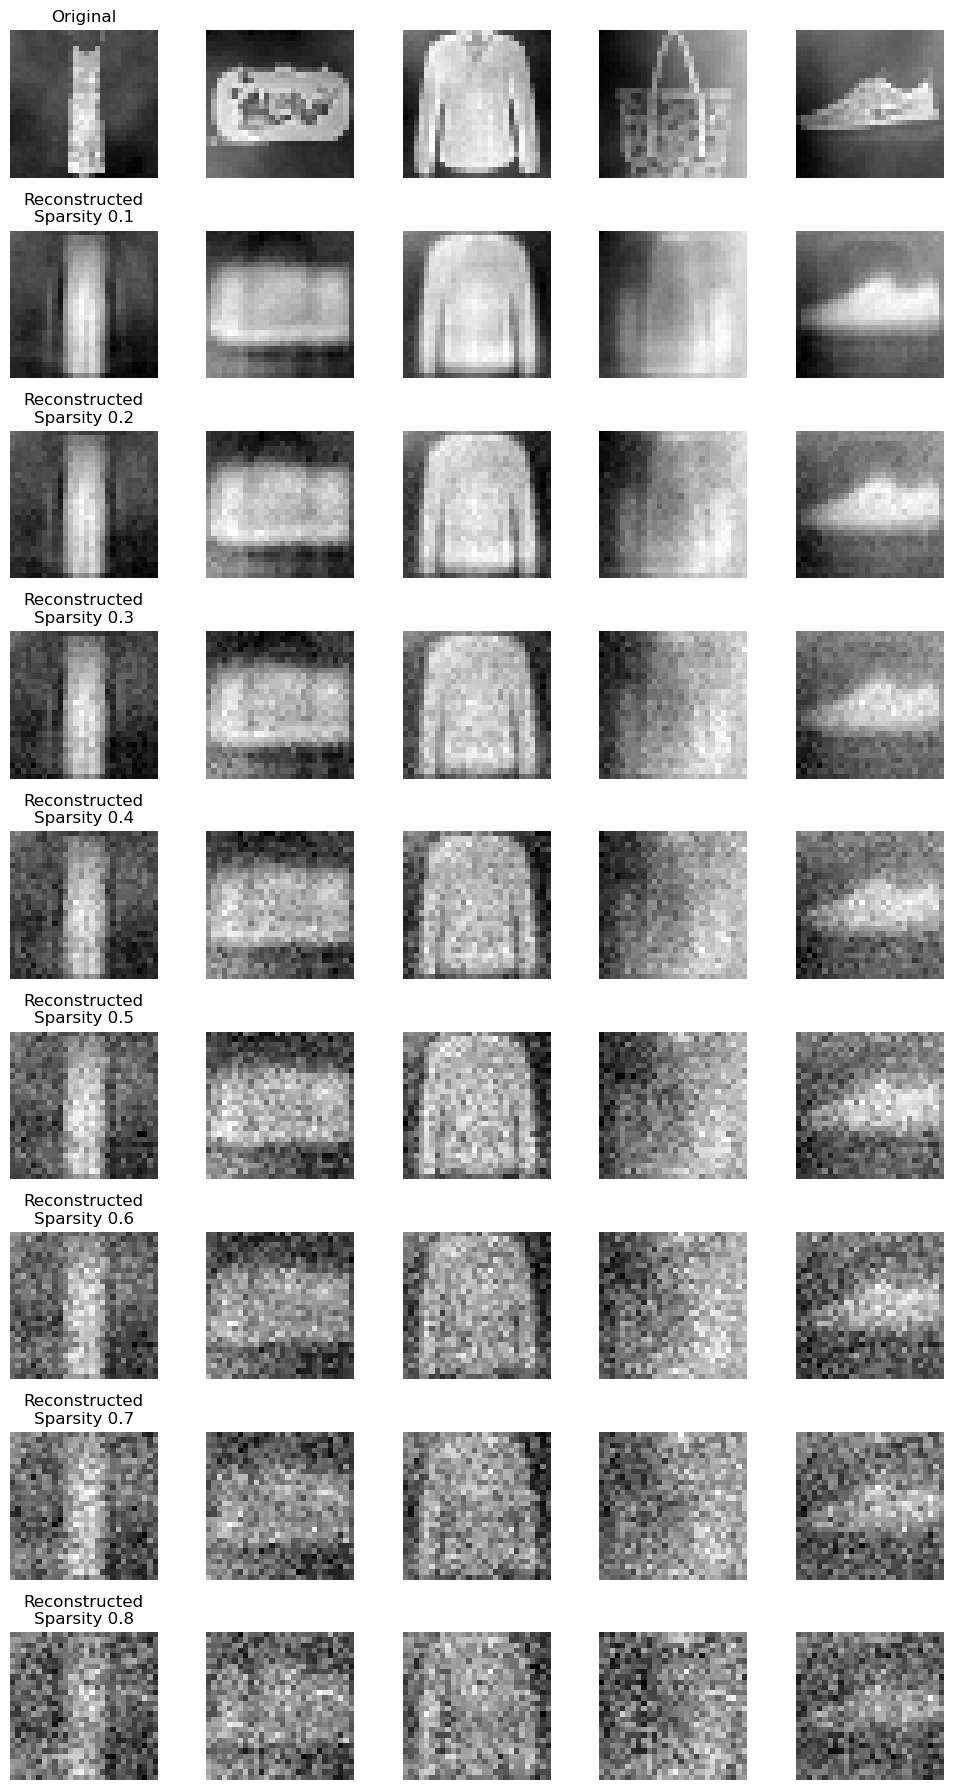

In [16]:
import matplotlib.pyplot as plt
import torch
import copy

def display_reconstructed_images(model, test_dataloader, prune_ratios):
    # Select a batch of images from the test DataLoader.
    test_images, _ = next(iter(test_dataloader))
    original_images = test_images.view(test_images.size(0), -1)

    # Set the number of images to display
    num_images_to_show = 5
    fig, axes = plt.subplots(len(prune_ratios) + 1, num_images_to_show, figsize=(num_images_to_show * 2, 2 * (len(prune_ratios) + 1)))

    # Display original images
    for i in range(num_images_to_show):
        ax = axes[0][i]
        ax.imshow(original_images[i].view(28, 28).cpu().numpy(), cmap='gray')  # Adjust dimensions for your dataset
        ax.axis('off')
        if i == 0:
            ax.set_title('Original')

    # Display reconstructed images at each sparsity level
    for j, sparsity in enumerate(prune_ratios, start=1):
        # Prune the model copy at the current sparsity level
        pruned_model = copy.deepcopy(model)
        apply_lap(pruned_model, [sparsity] * len(pruned_model.hidden_sizes), bn_factors=None)

        # Generate reconstructed images from the pruned model
        pruned_model.eval()
        with torch.no_grad():
            reconstructed_images = pruned_model(original_images).cpu()

        # Plot the reconstructed images
        for i in range(num_images_to_show):
            ax = axes[j][i]
            ax.imshow(reconstructed_images[i].view(28, 28).cpu().numpy(), cmap='gray')  # Adjust dimensions for your dataset
            ax.axis('off')
            if i == 0:
                ax.set_title(f'Reconstructed\nSparsity {sparsity}')

    plt.tight_layout()
    plt.show()

# Assuming 'model' is the trained AutoEncoder, 'test_dataloader' is defined,
# and 'prune_ratios' is a list of desired sparsity levels
display_reconstructed_images(model, test_dataloader, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])


In [5]:
data = 'DataPreparation/CorruptedMNIST/Names.csv'
root_dir = 'DataPreparation/CorruptedMNIST'
dataset = CustomDataSet(data, root_dir,transform=transform)

In [6]:
# finding the best parameters for autoencoder 
train_size = int(0.8 * len(dataset))  # 80% for training
validation_size = int(0.1*len(dataset))
test_size = len(dataset)-(train_size+validation_size)
train_dataset,validation_dataset,test_dataset,_ = random_split(dataset,[0.1,0.1,0.1, 0.7])
print(train_size)
print(validation_size)

# Create DataLoader instances
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(validation_dataset,batch_size=64,shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64,shuffle=True)

48000
6000


In [7]:
model_MNIST = AutoEncoder(input_size=784,bottleneck_size=50,hidden_sizes=[128, 64] ,layers=2)
train_losses,val_losses = train_autoencoder(model_MNIST, train_loader=train_dataloader,val_loader=validation_dataloader,epochs=100,lr=0.0003)

Epoch 1, Train Loss: 0.0801, Val Loss: 0.0391
Epoch 2, Train Loss: 0.0376, Val Loss: 0.0350
Epoch 3, Train Loss: 0.0331, Val Loss: 0.0310
Epoch 4, Train Loss: 0.0297, Val Loss: 0.0291
Epoch 5, Train Loss: 0.0286, Val Loss: 0.0275
Epoch 6, Train Loss: 0.0261, Val Loss: 0.0252
Epoch 7, Train Loss: 0.0246, Val Loss: 0.0240
Epoch 8, Train Loss: 0.0236, Val Loss: 0.0232
Epoch 9, Train Loss: 0.0225, Val Loss: 0.0217
Epoch 10, Train Loss: 0.0210, Val Loss: 0.0201
Epoch 11, Train Loss: 0.0196, Val Loss: 0.0192
Epoch 12, Train Loss: 0.0189, Val Loss: 0.0187
Epoch 13, Train Loss: 0.0185, Val Loss: 0.0184
Epoch 14, Train Loss: 0.0182, Val Loss: 0.0180
Epoch 15, Train Loss: 0.0178, Val Loss: 0.0178
Epoch 16, Train Loss: 0.0176, Val Loss: 0.0174
Epoch 17, Train Loss: 0.0172, Val Loss: 0.0170
Epoch 18, Train Loss: 0.0168, Val Loss: 0.0167
Epoch 19, Train Loss: 0.0164, Val Loss: 0.0163
Epoch 20, Train Loss: 0.0161, Val Loss: 0.0159
Epoch 21, Train Loss: 0.0157, Val Loss: 0.0156
Epoch 22, Train Loss: 

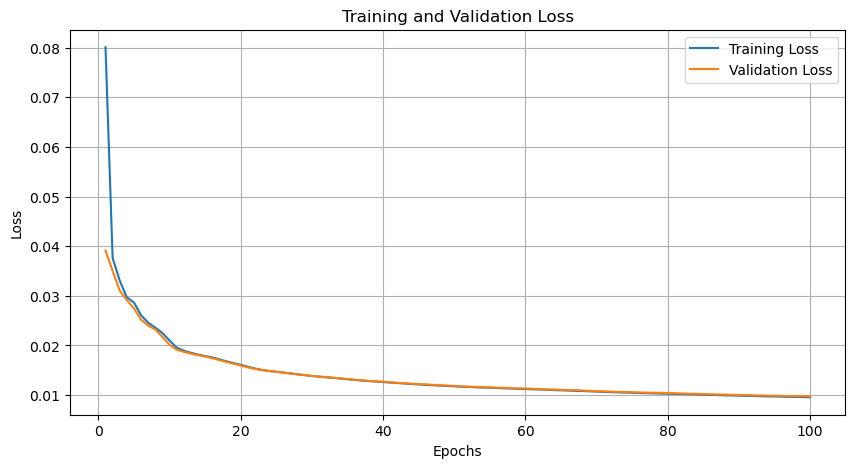

In [8]:
import matplotlib.pyplot as plt

# Assuming train_losses and val_losses are the lists returned from the train_autoencoder method
epochs = range(1, 100 + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
with open("Classifiers/MNISTClassifier.pkl", "rb") as f:
    mnist_classifier = pickle.load(f)

In [46]:
import copy
import matplotlib.pyplot as plt
from Pruning.LookaheadPruning import apply_lap, calculate_sparsity

# Assuming 'model' is your pre-trained AutoEncoder and 'test_dataloader' is defined
prune_ratios = [0.02, 0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9]  # Define desired prune ratios to apply
sparsity_levels_LAP = []  # This will store the actual sparsity levels calculated from the model
test_losses_LAP = []

for ratio in prune_ratios:
    # Create a deep copy of the trained model to apply pruning
    pruned_model = copy.deepcopy(model_MNIST)
    
    # Apply LAP pruning using the specified prune ratio
    apply_lap(pruned_model, [ratio] * len(pruned_model.hidden_sizes), bn_factors=None)
    
    # Calculate the actual sparsity level of the pruned model
    sparsity = calculate_sparsity(pruned_model)
    sparsity_levels_LAP.append(sparsity)
    
    # Evaluate the pruned model on the test dataset
    test_loss = eval_model(pruned_model, test_dataset, mnist_classifier)
    test_losses_LAP.append(test_loss)
    print(f"Prune Ratio: {ratio}, Actual Sparsity Level: {sparsity:.4f}, Test Loss: {test_loss:.4f}")


Prune Ratio: 0.02, Actual Sparsity Level: 0.0180, Test Loss: 0.9412
Prune Ratio: 0.2, Actual Sparsity Level: 0.1796, Test Loss: 0.9392
Prune Ratio: 0.3, Actual Sparsity Level: 0.2694, Test Loss: 0.9330
Prune Ratio: 0.4, Actual Sparsity Level: 0.3592, Test Loss: 0.9282
Prune Ratio: 0.5, Actual Sparsity Level: 0.4490, Test Loss: 0.9085
Prune Ratio: 0.6, Actual Sparsity Level: 0.5388, Test Loss: 0.8817
Prune Ratio: 0.7, Actual Sparsity Level: 0.6286, Test Loss: 0.8202
Prune Ratio: 0.8, Actual Sparsity Level: 0.7184, Test Loss: 0.7060
Prune Ratio: 0.9, Actual Sparsity Level: 0.8082, Test Loss: 0.2745


In [47]:
test_data = [data for data in test_dataloader]
importances_mnist = SSAE.calc_importance(model_MNIST,test_data[0][0])

0it [00:00, ?it/s]
100%|██████████| 8/8 [01:04<00:00,  8.08s/it]
1it [01:04, 64.67s/it]
100%|██████████| 21/21 [03:05<00:00,  8.85s/it]
3it [04:10, 85.57s/it]
  2%|▏         | 4/251 [00:35<35:47,  8.70s/it]divide by zero encountered in log
invalid value encountered in divide

  2%|▏         | 5/251 [00:43<34:46,  8.48s/it]divide by zero encountered in log
invalid value encountered in divide

  2%|▏         | 6/251 [00:51<34:11,  8.37s/it]divide by zero encountered in log
invalid value encountered in divide

 10%|▉         | 24/251 [03:23<31:29,  8.32s/it]divide by zero encountered in log
invalid value encountered in divide

 10%|▉         | 25/251 [03:32<31:22,  8.33s/it]divide by zero encountered in log
invalid value encountered in divide

 13%|█▎        | 32/251 [04:29<30:07,  8.25s/it]divide by zero encountered in log
invalid value encountered in divide

 13%|█▎        | 33/251 [04:38<30:06,  8.29s/it]divide by zero encountered in log
invalid value encountered in divide

 14%|█▎    

In [48]:
import Pruning.ShapSAE as SSAE

# Assuming 'model' is your pre-trained AutoEncoder and 'test_dataloader' is defined
prune_ratios = [0.02, 0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9]  # Define desired prune ratios to apply
sparsity_levels = []  # This will store the actual sparsity levels calculated from the model
test_losses = []
pruned_model = copy.deepcopy(model_MNIST)



for ratio in prune_ratios:
    # Create a deep copy of the trained model to apply pruning
    pruned_model = copy.deepcopy(model_MNIST)
    
    # Apply LAP pruning using the specified prune ratio
    pruned_model, _ = SSAE.prune(pruned_model, importances_mnist, ratio)
    
    
    # Evaluate the pruned model on the test dataset
    test_loss = eval_model(pruned_model, test_dataset, mnist_classifier)
    test_losses.append(test_loss)
    print(f"Prune Ratio: {ratio}, Actual Sparsity Level: {sparsity:.4f}, Test Loss: {test_loss:.4f}")


5it [00:00, 832.70it/s]


Prune Ratio: 0.02, Actual Sparsity Level: 0.8082, Test Loss: 0.8410


5it [00:00, 833.49it/s]


Prune Ratio: 0.2, Actual Sparsity Level: 0.8082, Test Loss: 0.3798


5it [00:00, 1000.26it/s]


Prune Ratio: 0.3, Actual Sparsity Level: 0.8082, Test Loss: 0.1598


5it [00:00, 982.73it/s]


Prune Ratio: 0.4, Actual Sparsity Level: 0.8082, Test Loss: 0.1277


5it [00:00, 999.41it/s]


Prune Ratio: 0.5, Actual Sparsity Level: 0.8082, Test Loss: 0.1172


5it [00:00, 998.41it/s]


Prune Ratio: 0.6, Actual Sparsity Level: 0.8082, Test Loss: 0.1172


5it [00:00, 1000.36it/s]


Prune Ratio: 0.7, Actual Sparsity Level: 0.8082, Test Loss: 0.1172


5it [00:00, 999.79it/s]


Prune Ratio: 0.8, Actual Sparsity Level: 0.8082, Test Loss: 0.1172


5it [00:00, 999.50it/s]


Prune Ratio: 0.9, Actual Sparsity Level: 0.8082, Test Loss: 0.1172


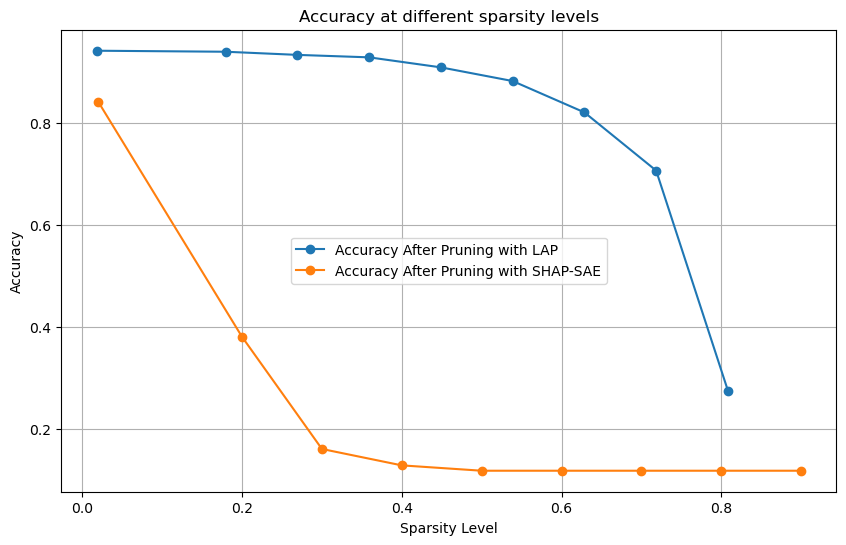

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(sparsity_levels_LAP, test_losses_LAP, '-o', label='Accuracy After Pruning with LAP')
plt.plot(prune_ratios, test_losses, '-o', label='Accuracy After Pruning with SHAP-SAE')


plt.xlabel('Sparsity Level')
plt.ylabel('Accuracy')
plt.title('Accuracy at different sparsity levels')
plt.legend()
plt.grid(True)
plt.show()

5it [00:00, 832.63it/s]
5it [00:00, 833.63it/s]
5it [00:00, 999.98it/s]
5it [00:00, 999.93it/s]
5it [00:00, 1000.31it/s]
5it [00:00, 999.60it/s]
5it [00:00, 999.88it/s]
5it [00:00, 833.16it/s]


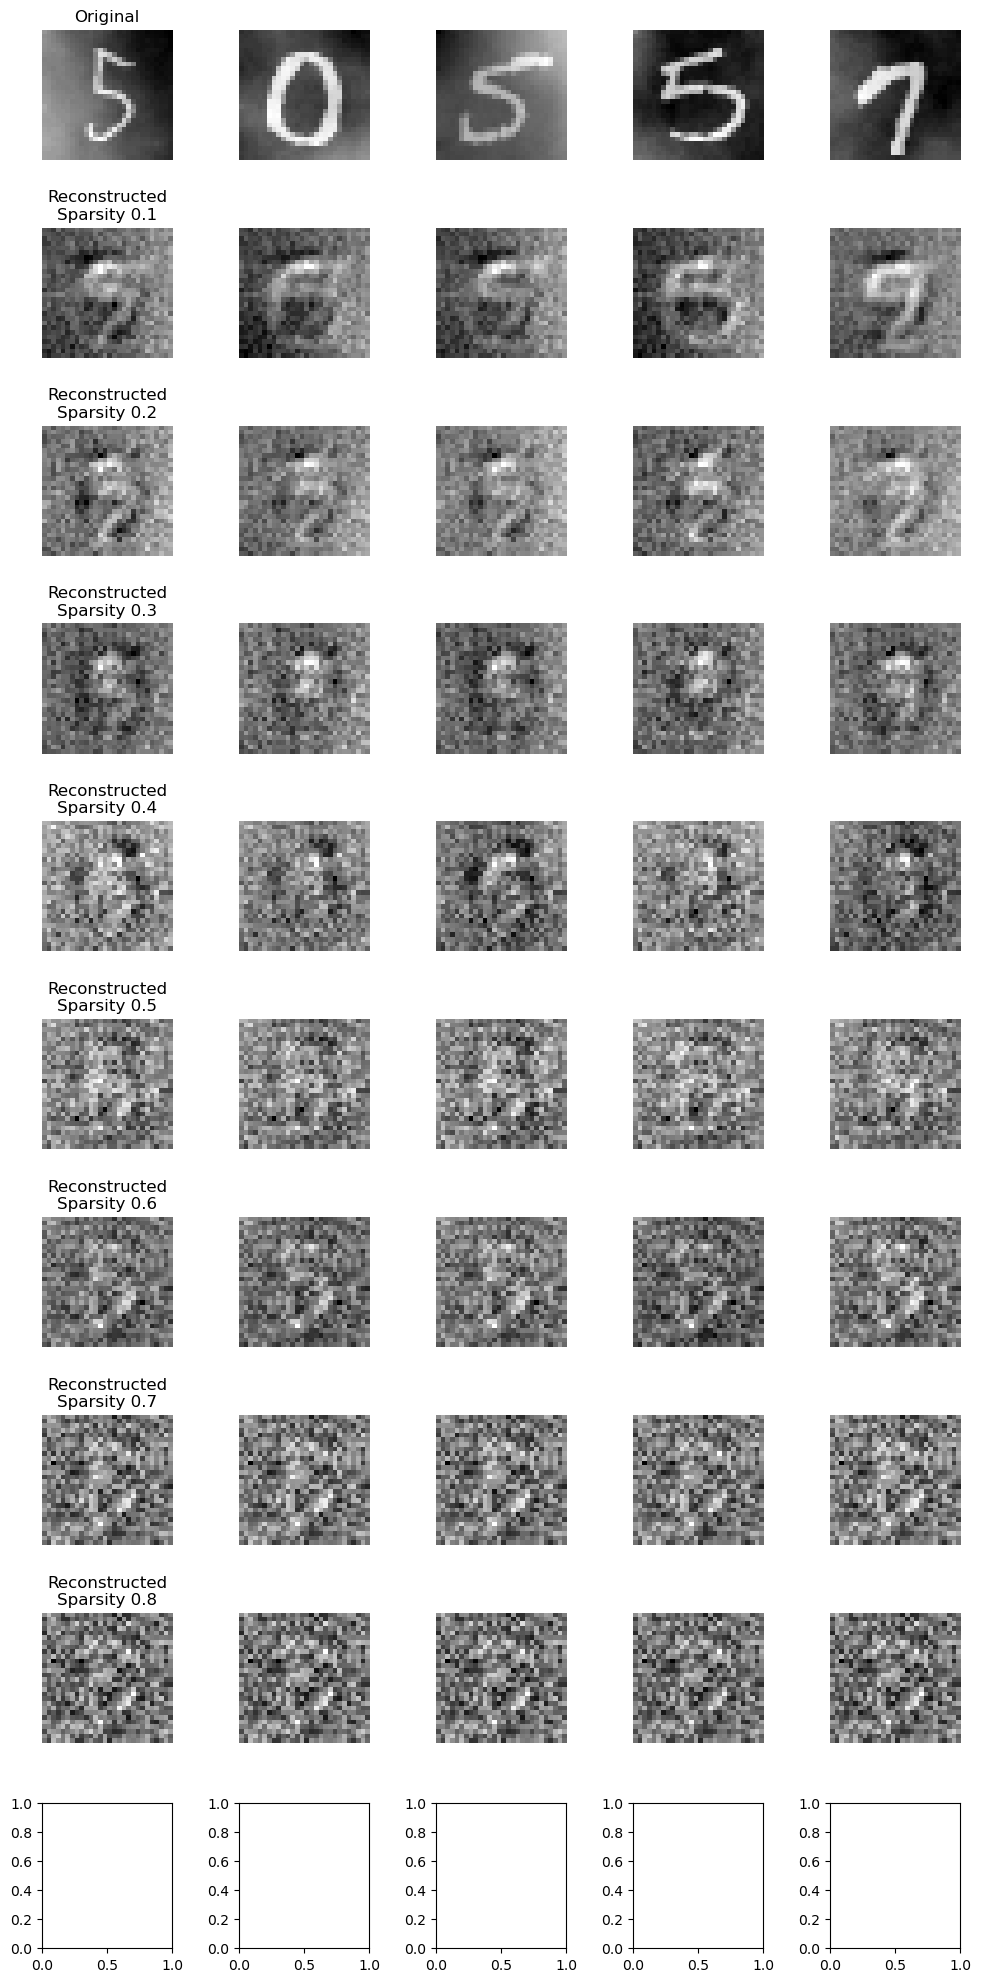

In [50]:
display_reconstructed_images_SHAP(model_MNIST, test_dataloader, importances, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

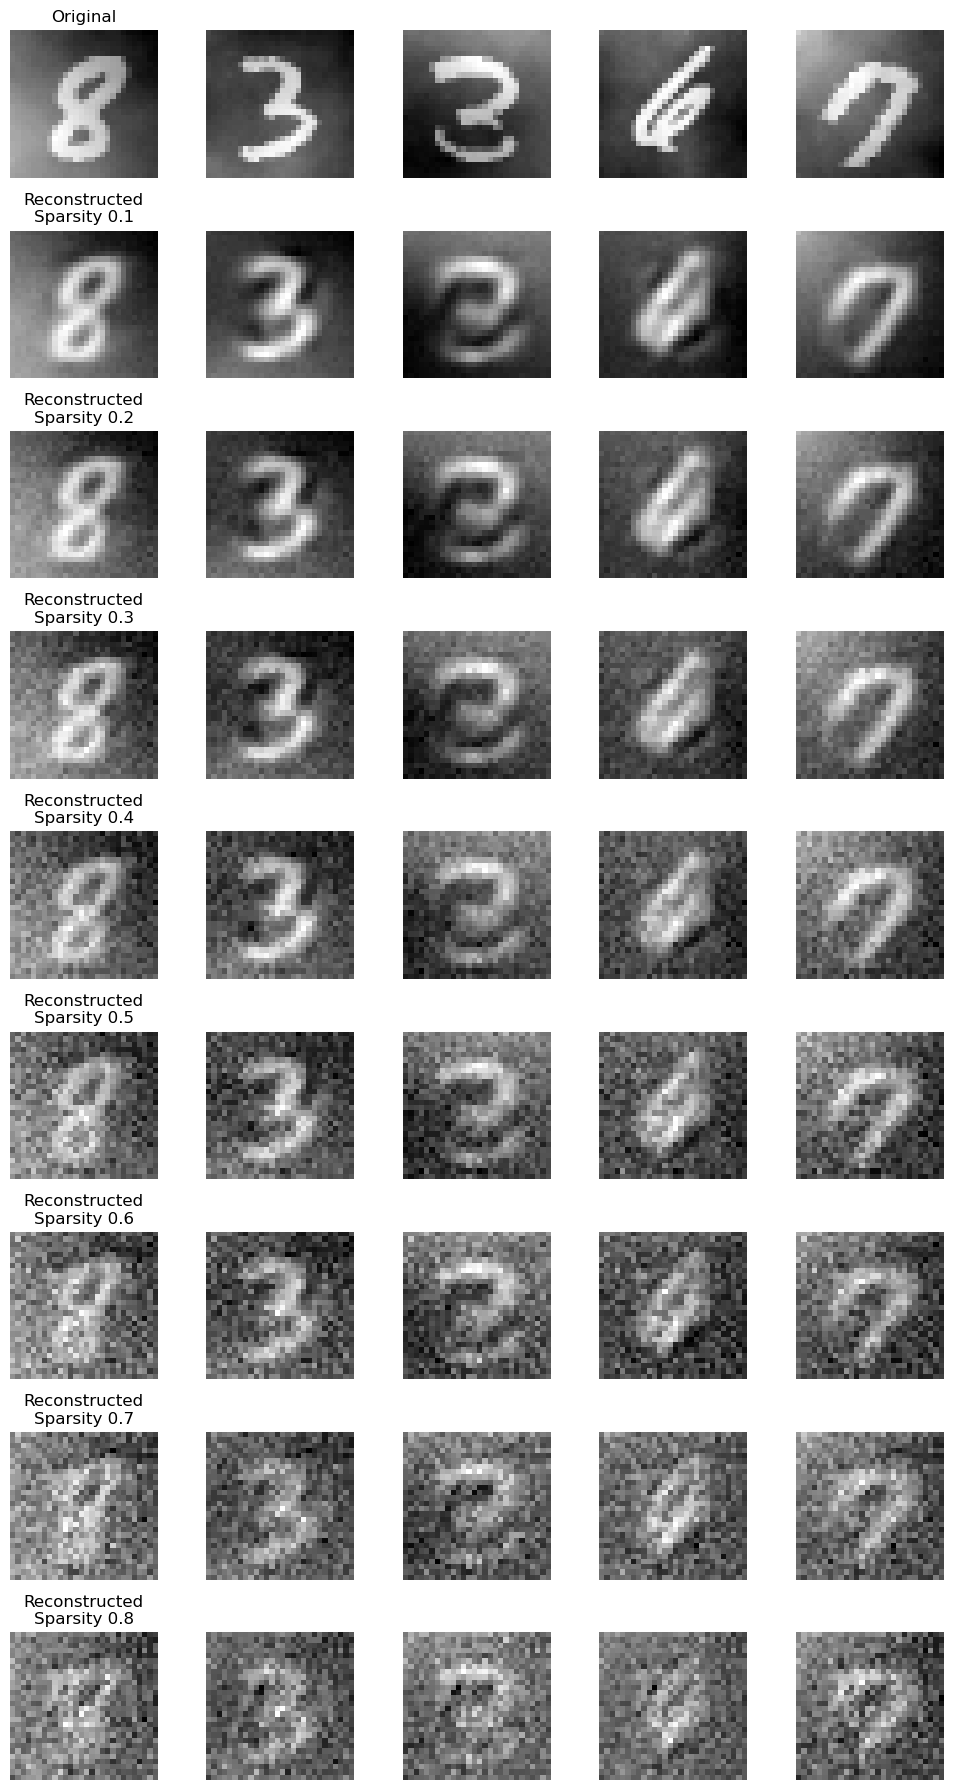

In [51]:
display_reconstructed_images(model_MNIST, test_dataloader, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])